In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from kernels import Kernels

# Bi-directional reflectance density function (BRDF) modelling for fun and profit

## Introduction
This post introduces simple BRDF modelling (i.e. how can we account for the variation in surface reflectance due to  acquisition geometry?) using some MODIS data. The techniques are fairly general, and can be applied to other sensors, but generally speaking, we are thinking of wide swath coarse resolution sensors such as Sentinel3/OLCI or VIIRS.

BRDF effects are basically effects derived from changes in both illumination and sensor geometry (or in the context of remote sensing in the solar reflective domain, sun and sensor position). The land surface is generally sepaking *anisotropic*, so that its reflectance varies with changes in the aforementioned geometries. This effect, particularly egregious in wide swath sensors results in a typical noise-like "fuzziness" if you look at a time series of data. The effect is physical, and if you don't compensate for it, it looks for noise, and can even cause important biases that may lead you to pretty wrong conclusions [e.g.](https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/20140017088.pdf)[DOI:10.1038/nature1300](http://doi.org/10.1038/nature1300)

A particularly simple way of dealing with BRDF effects is by using linear kernel models. These models are reduced physics versions of more complex radiative tranfer models with some empirical considerations to further simplify things. Since we are only interested in the shape of the BRDF, we can lump the parameters into some constants of limited physical explanatory value, and do a few simplifications so that we can write the the observed reflectance at band $\lambda_i$ as:

$$
\rho^{\lambda_i}(\Omega, Omega') = \sum_{i=1}^{N_{kern}}f_{i}(\lambda_i)K_{i}(\Omega, \Omega'),
$$

where we have $N_{kern}$ kernels, typically 3, and the acquisition geometry is given by $(\Omega, Omega')$. The three kernels that are typically used are those that have been popularised by the MODIS albedo product (MCD43):

*  An isotropic kernel, ($K_{iso}=1$), accounting for isotropic  BRDF effects (bet you didn't see that one coming...),
*  A volumetric scattering kernel ($K_{vol}(\Omega, \Omega')$), a simplified version of volume scattering as seen in Ross (1981),
*  A geometric scattering that aims to mimick surface scattering and shadowing, $K_{geo}(\Omega, \Omega')$.

While different families of these kernels are used, we use the Ross-ThickLiSparse-Reciprocal kernels (these have been evaluated and found to be quite general and overall "pretty good"). Note that the kernel functions are independent of wavelength: they just describe a shape in $(\Omega, \Omega')$ space.

The problem stated above cannot be solved on a daily basis (or whenever an observation becomes available): there are 3 parameters per band, and only one observation, so the system is underdetermined. If we assume that the parameters can be related to land surface parameters, and we assume that change is slow, a way around this is temporal compositing, where all the observations within a given period are inverted together.

It is important to take uncertainty in the observations into account, as we don't measure $\rho^{\lambda_i}$ , but rather
$\hat{\rho}^{\lambda_i} = \rho^{\lambda_i} + \epsilon^{\lambda_i}$, where $\epsilon^{\lambda_i}$ is additive noise, typically modelled as zero mean and with a known variance (this is bollocks, by the way, as the uncertainty will vary in function of the atmospheric correction. But since no-one bothers with this, we'll assume that it's constant!).

## Ill-posedness

The problem of inverting RT models (be they linear or not) is typically *ill-posed*. By contrast, a well-posed problem (in the Hadamard sense) is one where:

1. A solution exists
2. The solution is unique
3. The solution's behavior hardly changes when there's a slight change in the initial condition

In this case, due to the uncertainty introduced by the noise (and limited angular sampling), point 2 is not typically met, resulting in many configurations of kernel weights that provide an adequate representation of the observations. Compositing is a good way of increasing the angular sampling and reducing the noise, but it can only be taken that far: too long a compositing window, and the assumption of static land surface properties weakens.

## Reading the data

Let's look at some data. The data is stored in a text file, and belongs to a pixel somewhere in Angola. We only have band 2 data here. The first ten lines of the file show the format. The first line is a header, telling us that there are 92 observations, with 7 bands, as well as their centre wavelengths. After the first line, we have individual records with the following format:

*  day of year (DoY)
*  QA flag (1=use, 2=don't use)
*  `vza`, the view zenith angle (in degrees)
*  `vaa`, the view azimuth angle (in degrees)
*  `sza`, the solar/illumiation zenith angle (in degrees)
*  `saa`, the solar/illumiation azimuth angle (in degrees)
*  the reflectance

Typically, we will use `sza`, `vza` and `raa`. `raa=vaa - saa`.

First, we need to get the data. The data is stored in a file in this repository. Let's have a peek...

    



In [2]:
!head -n 10 data.r2023.c87.dat

BRDF 92 7 648 858 470 555 1240 1640 2130
181 1 65.419998 -84.470001 44.130001 20.090000 0.114600 0.243200 0.052800 0.087100 0.328300 0.302300 0.213400 
182 1 23.410000 98.290001 50.220001 35.310001 0.113900 0.218100 0.051100 0.084500 0.315900 0.339000 0.205500 
184 1 44.049999 100.730003 51.910000 38.360001 0.142900 0.269100 0.063400 0.107500 0.359300 0.375000 0.246500 
185 1 40.400002 -82.199997 46.310001 27.700001 0.107000 0.212100 0.051600 0.079900 0.310400 0.310400 0.214100 
186 1 57.720001 101.300003 53.700001 41.259998 0.152700 0.291400 0.064600 0.114800 0.395000 0.382700 0.258700 
187 1 17.770000 -81.010002 47.630001 31.260000 0.111000 0.217700 0.050500 0.081600 0.307600 0.318500 0.205500 
188 0 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 
189 1 10.470000 96.879997 49.090000 34.650002 0.117500 0.225000 0.054200 0.087700 0.334600 0.334300 0.231400 
190 1 60.889999 -83.790001 44.070000 22.910000 0.100200 0.212100 0.045900 0.07

OK, so far, so good. let's plot the data and do some crafty plots

Text(0, 0.5, '$\\hat{\\rho}^{NIR}$')

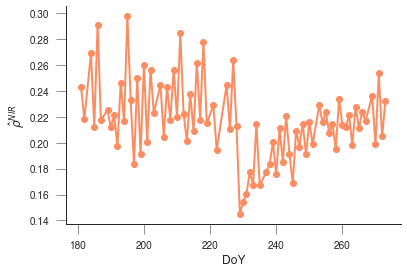

In [3]:
# Read data in, but skip first line
data = np.loadtxt("data.r2023.c87.dat", skiprows=1)
doys = data[:, 0]
qa = data[:, 1]
vza = data[:, 2]
sza = data[:, 4]
raa = data[:, 3] - data[:, 5]
rho = data[:, 7]
plt.plot(doys[qa == 1], rho[qa == 1], 'o-')
plt.xlabel("DoY")
plt.ylabel(r'$\hat{\rho}^{NIR}$')


So we see that there's quite a lot of noisiness over the time series, with a lot of high frequency variation. There's also an obvious drop in reflectance around DoY 228, which in this case was caused by a fire (there's a thermal anomaly on that day there too), and we can see that the reflectance recovers back to normal after that.

I'm telling you that a lot of that random-, noise-like behaviour is mostly changes in view/illumination geometry. We can plot the reflectance as a function of solar zenith before and after the fire

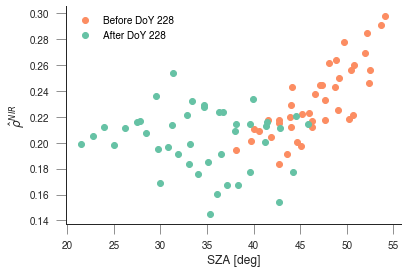

In [4]:
passer = np.logical_and(qa == 1, doys < 228)  # Select obs before the fire
plt.plot(sza[passer], rho[passer], 'o', label="Before DoY 228")
passer = np.logical_and(qa == 1, doys >= 228)  # Select obs before the fire
plt.plot(sza[passer], rho[passer], 'o', label="After DoY 228")

plt.xlabel("SZA [deg]")
plt.ylabel(r'$\hat{\rho}^{NIR}$')
plt.legend(loc="best", frameon=False)


Let's see if we can use the linear kernel models to... well, model this. First, let's calculate the different $K$ functions as a function of geometry. 

In [5]:
# Generate the kernels,
K_obs = Kernels(vza, sza, raa,
                LiType='Sparse', doIntegrals=False,
                normalise=1, RecipFlag=True, RossHS=False, MODISSPARSE=True,
                RossType='Thick')
n_obs = vza.shape[0]
kern = np.ones((n_obs, 3))  # Store the kernels in an array
kern[:, 1] = K_obs.Ross
kern[:, 2] = K_obs.Li


Let's fit the kernel weights ($f_0, f_1, f_2$) to the observations between DoY 200 and 209.

In [6]:
passer = np.logical_and(qa == 1, np.logical_and(doys > 200, doys <= 209))
obs = rho[passer]
K = kern[passer, :]
(f, rmse, rank, svals) = np.linalg.lstsq(K, obs, rcond=None)
print(f"{'kernel':20s}\t  {'Solved weight':20s}")
for i, k in enumerate(["Isotropic", "Ross", "LiThick"]):
    print(f"{k:20s}\t=>{f[i]:20f}")


kernel              	  Solved weight       
Isotropic           	=>            0.234025
Ross                	=>            0.046412
LiThick             	=>            0.053834


So we have a solution. How good is it? Let's try to forward model the observations:

R2: 0.950517


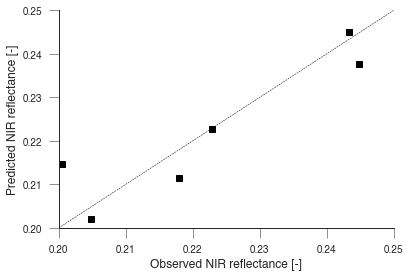

In [7]:
fwd = K.dot(f.T)
print(f"R2: {np.corrcoef (obs, fwd)[1,0]:g}")
plt.plot(obs, fwd, 'sk')
plt.plot([0.2, 0.25], [0.2, 0.25], 'k--', lw=0.5)
plt.ylim(0.2, 0.25)
plt.xlim(0.2, 0.25)
_ = plt.xlabel("Observed NIR reflectance [-]")
_ = plt.ylabel("Predicted NIR reflectance [-]")

That's pretty encouraging: Over around a week, we can predict the observations with our kernels pretty well...

In [8]:
def invert_composite(qa, doys, rho, kern, doy_min, doy_max):
    """A function to invert reflectance assuming the kernels in `kern`,
    `qa` holds the QA data, `doys` the dates, and `rho` the actual
    observations. Will composite all observations between `doy_min` and
    `doy_max`."""
    passer = np.logical_and(qa == 1, np.logical_and(
        doys > doy_min, doys <= doy_max))
    if np.sum(passer) < 3:
        raise np.linalg.LinAlgError
    obs = rho[passer]
    K = kern[passer, :]
    (f, rmse, rank, svals) = np.linalg.lstsq(K, obs, rcond=None)
    print(f"N. Obs: {np.sum(passer):d}")
    print(f"{'kernel':20s}\t  {'Solved weight':20s}")
    for i, k in enumerate(["Isotropic", "Ross", "LiThick"]):
        print(f"{k:20s}\t=>{f[i]:20f}")
    fwd = K.dot(f.T)
    print(f"R2: {np.corrcoef (obs, fwd)[1,0]:g}")
    _ = plt.plot(obs, fwd, 'sk')
    _ = plt.plot([0.05, 0.3], [0.05, 0.3], 'k--', lw=0.5)
    _ = plt.ylim(0.05, 0.3)
    _ = plt.xlim(0.05, 0.3)
    return obs, fwd, passer, f, rmse


Check we do as we expect...

N. Obs: 9
kernel              	  Solved weight       
Isotropic           	=>            0.234247
Ross                	=>            0.045438
LiThick             	=>            0.054025
R2: 0.951876


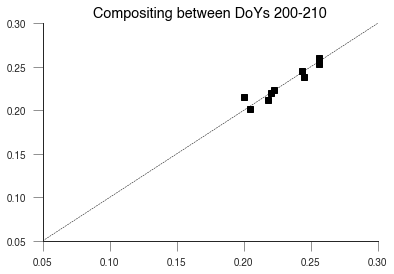

In [9]:
retval = invert_composite ( qa, doys, rho, kern, 200, 210 )
_ = plt.title("Compositing between DoYs 200-210")


Assume the surface parameters are identical over DoY 200-227:

N. Obs: 23
kernel              	  Solved weight       
Isotropic           	=>            0.228393
Ross                	=>            0.081972
LiThick             	=>            0.045487
R2: 0.951493


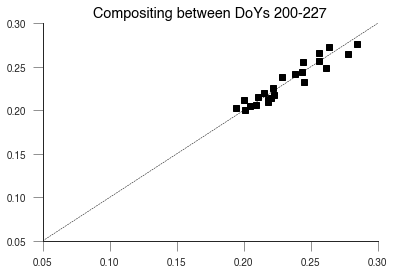

In [10]:
retval = invert_composite ( qa, doys, rho, kern, 200, 227 )
_ = plt.title("Compositing between DoYs 200-227")

Getting carried away: assume the surface parameters are identical over entire period (stupid thing to do, as there's clearly something happening at DoY 228!)

N. Obs: 84
kernel              	  Solved weight       
Isotropic           	=>            0.207380
Ross                	=>            0.110985
LiThick             	=>            0.017489
R2: 0.637027


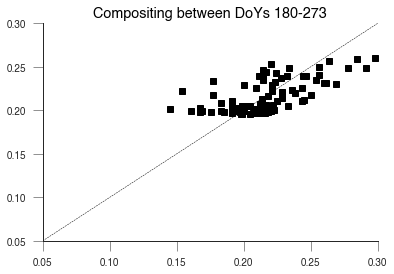

In [11]:
retval = invert_composite ( qa, doys, rho, kern, 180, 273 )
_ = plt.title("Compositing between DoYs 180-273")

So this is a bit rubbish. The asumption of stationary kernel weights is clearly violated here. But maybe we can bunch up observations in say 16 day periods and produce a meaningful tracking of dynamics.

181-189
N. Obs: 6
kernel              	  Solved weight       
Isotropic           	=>            0.212784
Ross                	=>            0.238125
LiThick             	=>           -0.015570
R2: 0.963866
189-197
N. Obs: 8
kernel              	  Solved weight       
Isotropic           	=>            0.229369
Ross                	=>            0.084185
LiThick             	=>            0.061499
R2: 0.927713
197-205
N. Obs: 7
kernel              	  Solved weight       
Isotropic           	=>            0.242792
Ross                	=>            0.010517
LiThick             	=>            0.100670
R2: 0.967032
205-213
N. Obs: 8
kernel              	  Solved weight       
Isotropic           	=>            0.229724
Ross                	=>            0.088585
LiThick             	=>            0.044736
R2: 0.987525
213-221
N. Obs: 7
kernel              	  Solved weight       
Isotropic           	=>            0.223450
Ross                	=>            0.149826
LiThick             	=

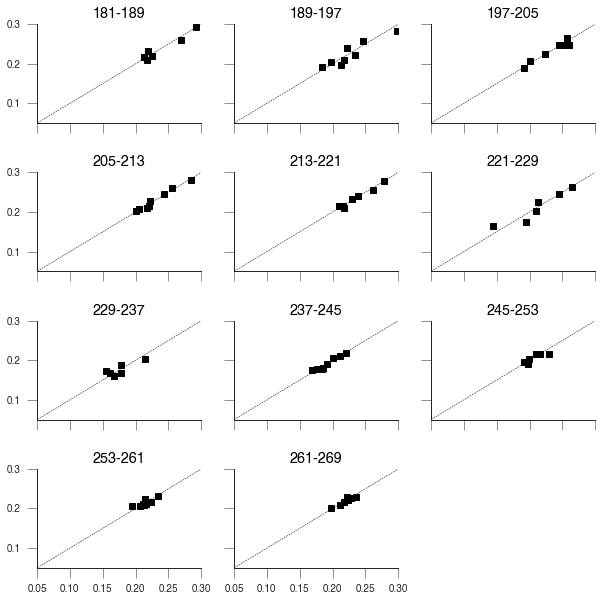

In [12]:
fig, axs = plt.subplots(nrows=4, ncols=3, sharex=True, sharey=True, squeeze=True, figsize=(10,10))
axs = axs.flatten()
doy_start = 181
doy_end = doy_start + 8
f_arr = []
t_axs = []
rmses = []
i = 0
while doy_end <= 273:
    plt.sca(axs[i])
    print(f"{doy_start:d}-{doy_end:d}")
    obs, fwd, passer, f, rmse = invert_composite ( qa, doys, rho, kern, doy_start, doy_end )
    plt.title(f"{doy_start:d}-{doy_end:d}")
    doy_end = doy_end + 8
    doy_start = doy_start + 8
    i += 1
    t_axs.append((doy_start + doy_end)/2)
    f_arr.append(f)
    rmses.append(rmse)
axs[-1].set_visible(False)


So, it would appear that things work reasonably well... But look at the $R^2$ values... They're all pretty good ($R^2>0.9$), except for those after DoY 228. Clearly, the 228 period includes the fire, and after it, we have the very fast surface reflectance change due to fast char and ash dissipation. This suggests that while pre-fire, the surface may not be experiencing much of a change, the post-fire dynamics are fast and furious. Let's look at how the parameter vary:

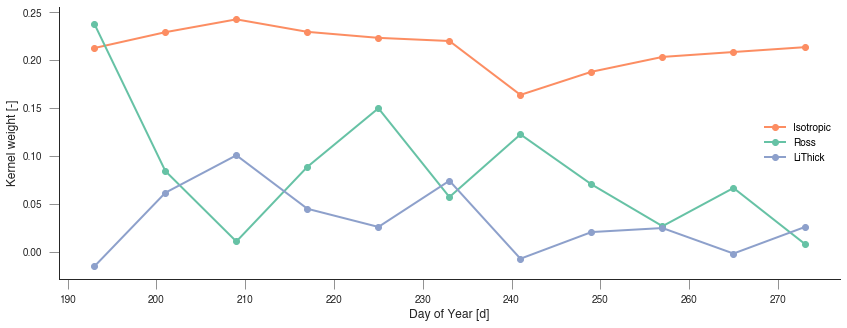

In [13]:
plt.figure(figsize=(14,5))
f = np.array(f_arr)
rmses = np.array(rmses)
for i, k in enumerate(["Isotropic", "Ross", "LiThick"]):
    plt.plot(t_axs, f[:, i], 'o-', label=k)
_ = plt.legend(loc="best", frameon=False)
_ = plt.xlabel("Day of Year [d]")
_ = plt.ylabel("Kernel weight [-]")

You can clearly see the drop in $f_0$ around the day of the fire, and the fast recovery afterwards. We also note that the other two kernels have a pretty haphazard temporal evolution. You can also check that if you change the periods (e.g. start at day 180, rather than 181), the solution for the isotropic is mostly the same, but the other two kernels can change dramatically. This is an acknowledgement of ill-posedness: small variations in the inputs can produce large variations in the outputs. In this case, we're quite close (and often below) the number of minimum observations to obtain a safe response. If we increase the temporal window to e.g. 10  or 16 days, we might get more stable retrievals, but at a coarser temporal resolution.

## Uncertainty

We haven't said anything about how uncertain data is. In this case, the solution will not change if we assume that all observations have the same uncertainty associated (e.g. $\sigma^2\sim 0.005$, say). But depending on things like SZA, VZA and other stuff, this will change. It's only that we don't know how. But let's see how this would work.

Assuming no correlation between uncertainty in observations, we have that 
$$
\hat{\rho}^{\lambda_i}(\Omega, Omega') = \sum_{i=1}^{N_{kern}}f_{i}(\lambda_i)K_{i}(\Omega, \Omega') + \mathcal{N}(0, \sigma_{obs}),
$$

which is an additive, zero mean, Gaussian noise model. We can calculate the minus log-likelihood derived from a set of observations that we stack in a vector $\vec{\rho}$, where we also stack the kernels into a matrix $\mathbf{K}$, and the uncertainties into a covariance matrix $\mathbf{C}_{obs}$ (in this case, diagonal), we have:

$$
\log\left[p(\rho|\vec{f}\right] \propto \frac{1}{2}\left[\vec{\rho^{\lambda_i}} - \vec{f}\cdot\mathbf{K}\right]^{\top}\mathbf{C}_{obs}^{-1}\left[\vec{\rho^{\lambda_i}} - \vec{f}\cdot\mathbf{K}\right]
$$

We can find the maximum likelihood estimate by finding the minimum minus log-likelihood estimate: we equate the derivative to 0 and we have your bog-standard linear least squares solution with uncertainty. The optical weights are given by

$$
\mathbf{K}^{\top}\mathbf{C}^{1}_{obs}\mathbf{K}\cdot \vec{f}_{opt} = \mathbf{K}^{\top}\mathbf{C}^{1}_{obs}\cdot\vec{\rho}
$$

And the uncertainty by the radius of curvature around the optimal point, or the inverse Hessian
$$
\mathbf{C}_{f}^{-1} = \mathbf{K}^{\top}\mathbf{C}^{1}_{obs}\mathbf{K}
$$

Implicitly, the solution is assumed to be multivariate Gaussian with mean $\vec{\rho}$ and covariance matrix $\mathbf{C}$

You may want to check [this document](https://doi.org/10.6084/m9.figshare.957577.v4) for a more thorough introduction to the maths behind this.

Let's see how this works in practice by using the `fit_period_prior` function:

In [14]:
def fit_period_prior(doys, qa, rho, start_doy, end_doy, band_unc, kernels,
                     prior_mean=None, prior_std=None):
    """Fit a period of observations

    doys: iter
        An array with the DoYs
    rho: iter
        A matrix (n_bands * n_obs) with observations
    start_doy: int
        A starting DoY
    end_doy: int
        An end DoY
    band_no: int
        The band number to use (indices the first dimension of rho)
    band_unc: float
        The per band_uncertainty
    kernels: iter
        The kernels matrix, size (n_obs * 3)
    """
    passer = np.logical_and(qa==1, np.logical_and(doys >= start_doy, doys <= end_doy))
    obs = rho[passer]

    n_obs = passer.sum()
    if n_obs < 7:
        raise np.linalg.LinAlgError
    K = kernels[passer, :]
    C = np.eye(n_obs)/(band_unc*band_unc)
    A = K.T @(C@K)
    b = (K.T.dot(C).dot(obs))
    
    if prior_mean is not None and prior_std is not None:
        C_prior = np.eye(3)/prior_std**2
        A = A + C_prior
        b = b + C_prior@(prior_mean)
    f = np.linalg.solve(A, b)
    fwd = K.dot(f)
    rmse = (obs - fwd).var()
    r2 = np.corrcoef(obs, fwd)[0, 1]
    the_unc = np.linalg.inv(A)
    sigma_f = np.sqrt(the_unc.diagonal())
    f_upper = K@(f - 1.96*sigma_f)
    f_lower = K@(f + 1.96*sigma_f)
    return f, fwd, obs, rmse, r2, the_unc, f_upper, f_lower, sigma_f


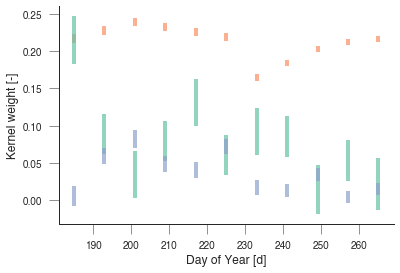

In [15]:
colors = ["#FC8D62", "#66C2A5", "#8DA0CB"]
doy_start = 181
doy_end = doy_start + 8
while doy_end <= 273:
    f, fwd, obs, rmse, r2, the_unc, f_upper, f_lower, sigma_f = fit_period_prior(
        doys, qa, rho, doy_start, doy_end, 0.005, kern)
    t0 = 0.5*(doy_start + doy_end)
    for i in range(3):
        plt.vlines(t0, f[i]-1.96*sigma_f[i], f[i]+1.96*sigma_f[i], 
                   color=colors[i], lw=4, alpha=0.7)
    
    doy_end = doy_end + 8
    doy_start = doy_start + 8
_ = plt.xlabel("Day of Year [d]")
_ = plt.ylabel("Kernel weight [-]")

We can see that the uncertainty associated with the isotropic tends to be smaller than that associated with the other two kernels. This suggests that they are less well defined, or in other words, we can select a larger spread of values to obtain a similar goodness of fit to the observations (Hadamard, we hear you!).


## Bayesian stuff

A clever way to improve on this might be to consider whether we can use the solution from the previous time step to constrain the solution from the current time step. Clever hey... In general, this is called "using a prior pdf", and is well known in the realm of Bayesian statistics (yeah, that weird bit that you never paid attention to because you were farting about with random forests or somesuch). Again, you may want to consult [this fine document](https://doi.org/10.6084/m9.figshare.957577.v4), and I will assume you understand most of it.

Basically, to the likelihood model we introduced above, Bayes' Rule states that the *a posteriori* probability of the model parameters ($\vec{f}$) given the observations ($\vec{\rho}$, $p(\vec{f}|\vec{\rho})$ is proportional to the product of the likelihood times the *a priori* pdf. 

$$
p(\vec{f}|\vec{\rho})\propto p(\vec{f}|\vec{\rho})\cdot p(\vec{rho})
$$

It turns out that the solution to this assuming a multivariate Gaussian pdf for the prior ($\mathcal{N}(\vec{f}_{prior}, \mathbf{C}_{prior}^{-1})$ is quite simple:
$$
\left[\mathbf{K}^{\top}\mathbf{C}^{1}_{obs}\mathbf{K} + \mathbf{C}_{prior}^{-1}\right]\cdot \vec{f}_{opt} = \mathbf{K}^{\top}\mathbf{C}^{1}_{obs}\cdot\vec{\rho} + \mathbf{C}^{1}_{prior}\cdot\vec{f}_{prior}
$$

The clever bit here is not to use the uncertainty from the posterior from the previous time step directly, as that is only pertinent to the previous timestep, but to add a bit of extra uncertainty to account for changes. How much uncertainty you add is entirely up to you, but if you add too much you'll be back to the original problem, and if you add too little, you'll over costrain the solution!

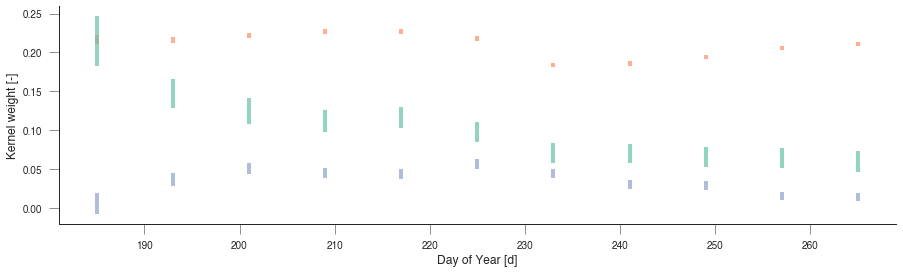

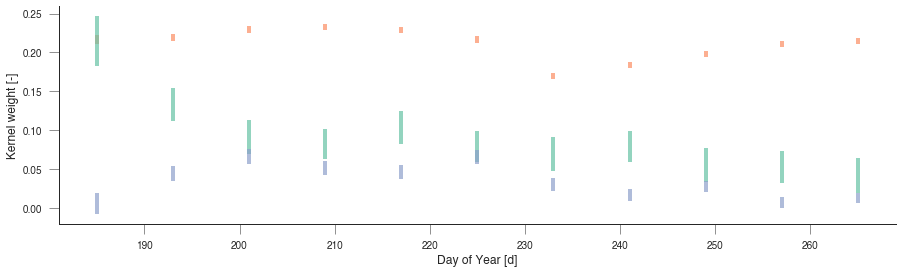

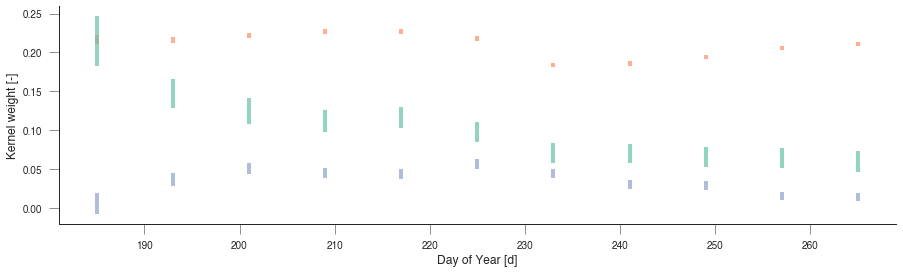

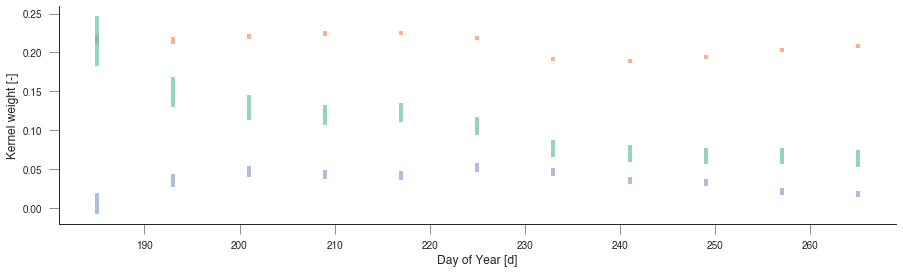

In [16]:

for add_unc in [0.001, 0.005, 0.001, 0.0005]:
    plt.figure(figsize=(15,4))
    colors = ["#FC8D62", "#66C2A5", "#8DA0CB"]
    prior_mean = np.array([0.2, 0., 0.])
    prior_std = np.array([0.5, 0.5, 0.5])
    doy_start = 181
    doy_end = doy_start + 8
    while doy_end <= 273:
        f, fwd, obs, rmse, r2, the_unc, f_upper, f_lower, sigma_f = fit_period_prior(
            doys, qa, rho, doy_start, doy_end, 0.005, kern, prior_mean=prior_mean,
            prior_std=prior_std)
        t0 = 0.5*(doy_start + doy_end)
        for i in range(3):
            plt.vlines(t0, f[i]-1.96*sigma_f[i], f[i]+1.96*sigma_f[i], 
                       color=colors[i], lw=4, alpha=0.7)
        prior_mean = f
        # Add some uncertainty!
        prior_std = sigma_f + np.ones(3)*add_unc
        doy_end = doy_end + 8
        doy_start = doy_start + 8
    _ = plt.xlabel("Day of Year [d]")
    _ = plt.ylabel("Kernel weight [-]")

The previous code snippet shows that you this prior idea is quite a good one to exploit. At this stage, you can just infer the parameters **every day** rather than every 8 days! If you do not have observations on a given day, you repeat the mean and just inflate the uncertainty.

Obviously, this is well-known and people have exploited it like forever. The most famous method is the Kalman filter, which is a re-arranging of the above equations into a super elegant algorithm

## The Kalman filter

In the Kalman filter, we assume that we have a *"state"*, which is the pdf of our parameters. We assume that this pdf is multivariate normal, with mean $\vec{f}_{a}^{k}$ and covariance $\mathbf{P}_{a}^{k}$ at time $k$. Going form $t=k\longrightarrow k+1$, we have that we have a linear dynamic model that propagates the state vector and its associated uncertainty. Our extra bit of uncertainty is now stored in a covariance matrix $\mathbf{Q}^{k}$
$$
\begin{align}
\vec{f}_{f}^{k+1} &= \mathbf{M}\cdot \vec{f}_{f}^{k} \\
\mathbf{P}_{f}^{k+1} &= \mathbf{M}\cdot \mathbf{P}_{f}^{k+1} + \mathbf{Q}^{k}\\
\end{align}
$$

In our previous case, the model $\mathbf{M}$ was just the identity matrix (we assume no dynamics), but you can have any linear or locally linear model. Now, to bring in the observations we have our likelihood equation from above. Combining these two, we start by defining a so called "Kalman gain", $\mathbf{G}$:

$$
\mathbf{G}^{k+1}=\mathbf{P}_{f}^{k}\mathbf{K}^{k+1}\cdot\left[\mathbf{K}^{k+1} \mathbf{P}_{f}^{k} \mathbf{K}^{\top\;k+1}  + \mathbf{C}_{obs}^{k+1}   \right]^{-1}
$$

Then, the update of the state in time $k+1$ is
$$
\vec{f}_{a}^{k+1} = \vec{f}_{f}^{k} + \mathbf{G}^{k+1}\left[\mathbf{K}^{k}\cdot\vec{f}_{f}^{k+1} - \vec{rho}^{k+1}   \right],
$$

and there's a similar  update equation for the "analysis" covariance matrix, but I can't be bothered to write it up.

All this looks quite clever:

1. You propagate your state from one time to the next with a linear model. The model is incorrect, so you account for that by inflating the uncertainty.
2. You then use that propagated state as a prior to invert the observations
3. As everything is nice and linear, there are analytic expressions that allow you to do that easily.

In [21]:
# Dynamic model related parameters
A = np.eye(3) # Dynamic model is identity!
Q = np.eye(3)*np.array([0.0001, 1e-6, 1e-6])  # Dynamic model uncertainty

# Starting point related parameters
f = np.array([0.25, 0.05, 0.05]) # Prior mean for f0, f1 and f2
P = np.eye(3)*np.array([0.1, 0.001, 0.001]) # Uncertainty in prior estimate

# Uncertainty in observations
R = np.eye(1)*0.005

kf_m = []
kf_P = []
innovations = []
# Loop over days
for k in doys:
    # Propagate state with dynamic model
    # and inflate uncertainty!
    f = A@f  
    P = A@P@A.T + Q  
    passer = (doys == k)
    # If we have an observation...
    if qa[passer] == 1 and rho[passer] > 0:
        # Retrieve observation operator
        H = kern[passer, :]
        # Kalman gain Kalculations...
        S = H@P@H.T + R
        K = (P@H.T)@np.linalg.inv(S)
        # Update state with new observations
        y = rho[passer] - H@f
        f = f + K@(y)
        P = P-K@S@K.T
        innovations.append(y)
    else:
        innovations.append(np.nan)
    kf_m.append(f)
    kf_P.append(P)
kf_m = np.array(kf_m)
kf_P = np.array(kf_P)
innovations = np.array(innovations)


We've run the KF on the data. We'll now plot the kernel weights (for every day!), as well as the innovations (whenever we have observations):

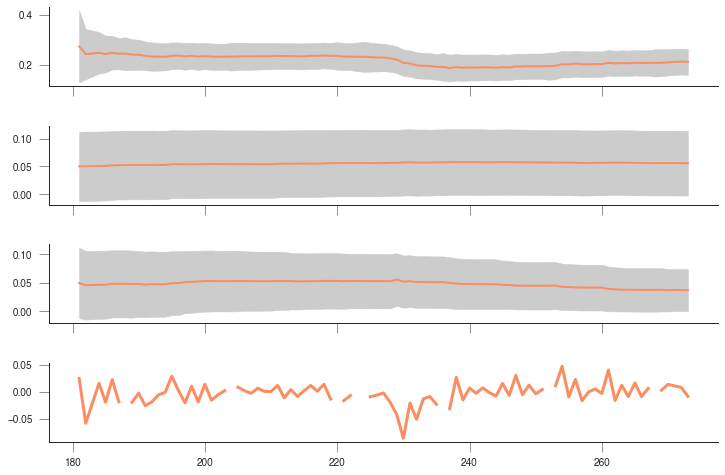

In [22]:
fig, axs = plt.subplots(nrows=4, ncols=1,  sharex=True, figsize=(12, 8))
axs = axs.flatten()
for i in range(3):
    sigma = np.array([np.sqrt(u.diagonal()[i]) for u in kf_P])
    axs[i].fill_between(doys, kf_m[:, i] - 1.96*sigma,
                kf_m[:, i] + 1.96*sigma, color="0.8")
    axs[i].plot(doys, kf_m[:, i], '-', lw=2)
axs[3].plot(doys, innovations, '-', lw=3)


We see that the isotropic kernel has the funnel shaped uncertainty typical of a filter: high at the start and decreasing as more and more observations are added. We can also see the large innovations around DoY 228, the day of the fire, which the filter smooths over ever so slightly! In some cases, adapting the value of $\mathbf{Q}$ might allow one to finesse in the change, although do not expect miracles.

## The Kalman smoother

The Kalman filter uses information from the previous time step to constrain the current one. But we could also run the filter backwards with the same reasoning, only time reversed. And because we'd be using completely different observations on each run, we could combine them together. This is broadly speaking what the Kalman smoother does.

Here, I have implemented the RTS (Rauch–Tung–Striebel) implementation, which is slightly more efficient than running to filters

In [33]:
ms = f
Ps = P
rts_m = [f]
rts_P = [P]


for k in range(n_obs-1, 0, -1):
    mf = A@kf_m[k, :] 
    Pp = A@kf_P[k, :, :]@A.T + Q 
    Ck = (kf_P[k, :, :]@A.T)@np.linalg.inv(Pp)
    ms = kf_m[k, :] + Ck@(ms-mf)
    Ps = kf_P[k, :, :] + Ck@(Ps-Pp)@Ck.T 
    rts_m.append(ms)
    rts_P.append(Ps)
rts_m = np.array(rts_m)
rts_P = np.array(rts_P)

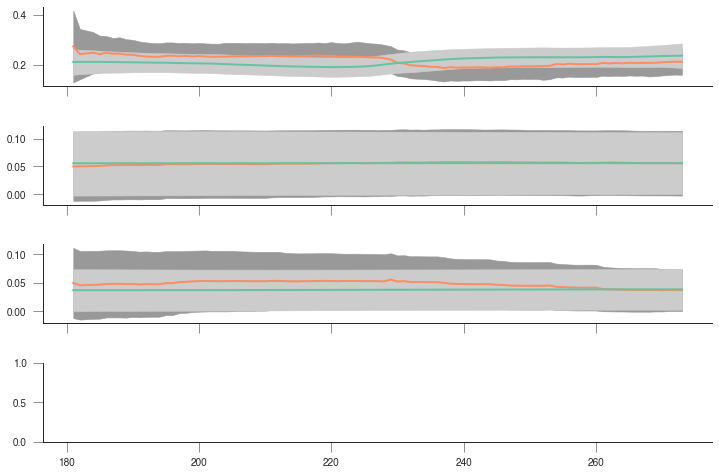

In [38]:
fig, axs = plt.subplots(nrows=4, ncols=1,  sharex=True, figsize=(12, 8))
axs = axs.flatten()
for i in range(3):
    sigma = np.array([np.sqrt(u.diagonal()[i]) for u in kf_P])
    axs[i].fill_between(doys, kf_m[:, i] - 1.96*sigma,
                kf_m[:, i] + 1.96*sigma, color="0.6")
    axs[i].plot(doys, kf_m[:, i], '-', lw=2)

    sigma = np.array([np.sqrt(u.diagonal()[i]) for u in rts_P])
    axs[i].fill_between(doys, rts_m[:, i] - 1.96*sigma,
                rts_m[:, i] + 1.96*sigma, color="0.8")
    axs[i].plot(doys, rts_m[:, i], '-', lw=2)
